In [ ]:
!git clone https://github.com/abhaybd/Cat-Dog-CNN-Classifier

Cloning into 'Cat-Dog-CNN-Classifier'...
remote: Enumerating objects: 10040, done.
remote: Total 10040 (delta 0), reused 0 (delta 0), pack-reused 10040
Receiving objects: 100% (10040/10040), 216.93 MiB | 20.45 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Checking out files: 100% (10011/10011), done.


In [ ]:
# Import libraries
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense

# Initalize CNN
classifier = Sequential()

# Add 2 convolution layers
classifier.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(64, 64, 3), activation='relu'))
classifier.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))

# Add pooling layer
classifier.add(MaxPooling2D(pool_size=(2,2)))

# Add 2 more convolution layers
classifier.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
classifier.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))

# Add max pooling layer
classifier.add(MaxPooling2D(pool_size=(2,2)))

# Add 2 more convolution layers
classifier.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
classifier.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))

# Add max pooling layer
classifier.add(MaxPooling2D(pool_size=(2,2)))

# Add global average pooling layer
classifier.add(GlobalAveragePooling2D())

# Add full connection
classifier.add(Dense(units=2, activation='softmax'))

# Compiling the ANN
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit CNN to images
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(
        'Cat-Dog-CNN-Classifier/dataset/training_set',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical')

test_set = test_datagen.flow_from_directory(
        'Cat-Dog-CNN-Classifier/dataset/test_set',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical')

classifier.fit_generator(
        train_set,
        steps_per_epoch=80,
        epochs=25,
        validation_data=test_set,
        validation_steps=20)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/25
80/80 [==============================] - 13s 161ms/step - loss: 0.6940 - accuracy: 0.4812 - val_loss: 0.6930 - val_accuracy: 0.4688
Epoch 2/25
80/80 [==============================] - 12s 150ms/step - loss: 0.6932 - accuracy: 0.4879 - val_loss: 0.6925 - val_accuracy: 0.4859
Epoch 3/25
80/80 [==============================] - 12s 150ms/step - loss: 0.6914 - accuracy: 0.5109 - val_loss: 0.7107 - val_accuracy: 0.5172
Epoch 4/25
80/80 [==============================] - 13s 158ms/step - loss: 0.6919 - accuracy: 0.4734 - val_loss: 0.6906 - val_accuracy: 0.4728
Epoch 5/25
80/80 [==============================] - 11s 144ms/step - loss: 0.6888 - accuracy: 0.5352 - val_loss: 0.6840 - val_accuracy: 0.5656
Epoch 6/25
80/80 [==============================] - 12s 149ms/step - loss: 0.6892 - accuracy: 0.5344 - val_loss: 0.6907 - val_accuracy: 0.5312
Epoch 7/25
80/80 [==============================] - 13s 15

In [ ]:

from keras.models import load_model, Model

layer_index = -3

weights = classifier.layers[-1].get_weights()[0]
classifier = Model(inputs=classifier.input,outputs=(classifier.layers[layer_index].output,classifier.layers[-1].output))

if layer_index >= 0:
    layer_index += 1
width_factor = classifier.layers[layer_index].output_shape[1]
height_factor = classifier.layers[layer_index].output_shape[2]

# Load image
import numpy as np

import matplotlib.pyplot as plt
def visualize(img):
    conv_out, guess = classifier.predict(img)
    print(guess)
    conv_out = np.squeeze(conv_out)
    for i in range(len(conv_out[0][0])):
        plt.figure()
        plt.imshow(conv_out[:,:,i])


def get_heatmap(image):
    conv_out, pred = classifier.predict(image)
    conv_out = np.squeeze(conv_out)
    pred = np.argmax(pred)
    from scipy.ndimage import zoom
    mat_for_mult = zoom(conv_out, (64./width_factor, 64./height_factor, 1), order=1)
    weights = classifier.layers[-1].get_weights()[0][:,int(pred)]
    out = np.dot(mat_for_mult.reshape((64*64, 32)), weights).reshape((64, 64))
    return pred, out

def get_bounds(out, percentile=95):
    # Get bounding box of 95+ percentile pixels
    a = out.flatten()
    filtered = np.array([1 if x > np.percentile(a, percentile) else 0 for x in a]).reshape(64,64)
    left, up, down, right = 64, 64, 0, 0
    for x in range(64):
        for y in range(64):
            if filtered[y,x] == 1:
                left = min(left, x)
                right = max(right, x)
                up = min(up, y)
                down = max(down, y)
    return left, up, down, right

from keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
        'Cat-Dog-CNN-Classifier/dataset/training_set',
        target_size=(64, 64),
        batch_size=1,
        class_mode='categorical')

def load_image(path):
    from PIL import Image
    img = Image.open(path)
    img = img.resize((64,64))
    arr = np.asarray(img)
    arr = arr/255.0
    return arr

def show_next(bounds=True, heatmap=True, show_image=True, image=[]):
    if len(image) == 0:
        img = test_set.next()[0]
    else:
        img = image
        img = np.expand_dims(img, axis=0)
    global out
    pred, out = get_heatmap(img)  
    
    # Plot Heatmap
    fig, ax = plt.subplots()
    ax.imshow(img[0], alpha=(0.7 if heatmap else 1.))
    if heatmap:
        ax.imshow(img[0]) #cmap='jet', alpha=(0.3 if show_image else 1.))
    if bounds:
        left, up, down, right = get_bounds(out)
        import matplotlib.patches as patches
        rect = patches.Rectangle((left, up), (right-left), (down-up), linewidth=1,  edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    if pred == 0:
        ax.set_title('Cat')
    else:
        ax.set_title('Dog')
    plt.show()

Found 8000 images belonging to 2 classes.


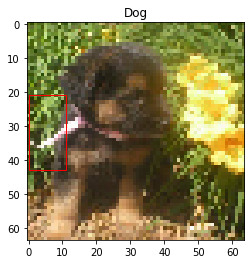

In [ ]:
show_next()